In [1]:
# Modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import datetime

# Functions
from implementations import *
from helpers import *

# Autoreload
%load_ext autoreload
%autoreload 2

# Set random seed
np.random.seed(1)


(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")
# labels_raw_portion = labels_raw[:10000]
# data_raw_portion = data_raw[:10000,:]
# ids_raw_portion = ids_raw[:10000]
data_, data_t_, labels = process_data(data_raw, t_data_raw, labels_raw, ids_raw, replace = 'mean')


The original dimensions of the training data set was 250000 samples and 30 columns
 After feature and sample filtering, there are 223877 samples and 23 columns


In [2]:
# Create train/test split

X_train, y_train, X_test, y_test = split_data(data_, labels, ratio=0.8, seed=1)

# Create standardizations for the split

X_train_std, mean, variance = standardize(X_train)
X_test_std = standardize_test(X_test, mean, variance)

# Initialize boxplots values

boxplots = []
test_accuracies = []

# Linear Regression: Gradient Descent

In [3]:
# Initialize w vector
initial_w = np.random.rand(data_.shape[1])
k_ = 4

# Perform linear regression by gradient descent with cross validation (k=4)
test_loss_mean, test_loss_var, vector_test_loss, train_loss_mean, w_final, accuracies = least_squares_GD(y_train, X_train, initial_w, gamma = 0.00005, k=k_, max_iters = 5000)
boxplots.append(accuracies)

# Perform linear regression by gradient descent on whole training set
w = least_squares_GD(y_train, X_train_std, initial_w, gamma = 0.00005, k=0, max_iters = 5000)

# Use w to predict unseen test set labels
test_pred_lab = predict_labels(w, X_test_std)
test_accuracy = pred_accuracy(test_pred_lab, y_test)
test_accuracies.append(test_accuracy)

In [4]:
# Write results to file

file_object = open('cv_results', 'w')
file_object.write('fold1, fold2, fold3, fold4, test_set \n')
acc_s = str(accuracies[0]) + ', ' + str(accuracies[1]) + ', ' + str(accuracies[2]) + ', ' + str(accuracies[3])
acc_t = str(test_accuracy) + '\n'
file_object.write(acc_s + ', ' + acc_t)


98

In [ ]:
plt.style.use('seaborn')
plt.boxplot(accuracies)
plt.plot(1, test_accuracy, marker='o', c='red')

# Linear Regression: Direct Least Squares

In [5]:
k_ = 4

# Perform linear regression by direct least squares with cross validation (k=4)
test_loss_mean, test_loss_var, train_loss_mean, w_final, accuracies = least_squares(y_train, X_train, k_)
boxplots.append(accuracies)

# Perform linear regression by direct least squares on whole training set
w = least_squares(y_train, X_train_std, k=0)

# Use w to predict unseen test set labels
test_pred_lab = predict_labels(w, X_test_std)
test_accuracy = pred_accuracy(test_pred_lab, y_test)
test_accuracies.append(test_accuracy)

In [6]:
acc_s = str(accuracies[0]) + ', ' + str(accuracies[1]) + ', ' + str(accuracies[2]) + ', ' + str(accuracies[3])
acc_t = str(test_accuracy) + '\n'
file_object.write(acc_s + ', ' + acc_t)
file_object.close()

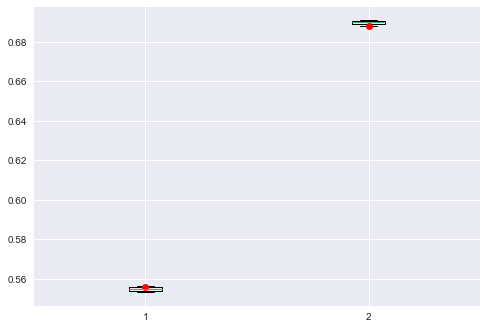

In [10]:
# Create boxplots

plt.style.use('seaborn')
plt.boxplot(boxplots)
plt.plot(1, test_accuracies[0], marker='o', c='red')
plt.plot(2, test_accuracies[1], marker='o', c='red')

In [ ]:
# #make a plot of the four k's to see how they vary over time

# means_over_time = vector_test_loss.mean(axis=0)
# error1 = abs(means_over_time - vector_test_loss[0])
# error2 = abs(means_over_time - vector_test_loss[1])
# error3 = abs(means_over_time- vector_test_loss[2])
# error4 = abs(means_over_time - vector_test_loss[3])
# x = np.arange(len(error1))


# plt.style.use('seaborn')
# # for i in np.arange(4):
# #     plt.plot(x, vector_test_loss[i], label= 'Trial {}'.format(i))
# plt.plot(x, vector_test_loss[0], label='Trial 1', c='red')
# plt.fill_between(x, vector_test_loss[0]-error1, vector_test_loss[0]+error1,
#     alpha=0.2, edgecolor='#CC4F1B', facecolor='#FF9848')
# plt.plot(x, vector_test_loss[1], label='Trial 2', c = 'green')
# plt.fill_between(x, vector_test_loss[1] - error2, vector_test_loss[1] + error2, alpha = 0.2, edgecolor='#FF3F1B', facecolor = '#12E99F')
# plt.plot(x, vector_test_loss[2], label='Trial 3', c='blue')
# plt.fill_between(x, vector_test_loss[2]-error3, vector_test_loss[2]+error3,
#     alpha=0.2, edgecolor='#CC4F1B', facecolor='#12E2FF')
# plt.plot(x, vector_test_loss[3], label='Trial 4', c='purple')
# plt.fill_between(x, vector_test_loss[3]-error4, vector_test_loss[3]+error4,
#     alpha=0.2, edgecolor='#CC4F1B', facecolor='#FF00FF')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Test Set Loss Over Iterations of Gradient Descent')
# plt.legend()
# plt.show()